In [1]:
import pathlib

import cdflib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.constants
import torch
from cdasws import CdasWs

from pymfr.detect import detect_flux_ropes
from pymfr.reconstruct import reconstruct_map

In [2]:
time = ['2018-11-13T00:00:00Z', '2018-11-14T00:00:00Z']

file_name = f"./data/psp_{time[0]}_{time[1]}_30s.npz"
if not pathlib.Path(file_name).exists():
    cdas = CdasWs()

    status, data = cdas.get_data('PSP_SWP_SPC_L3I', ['vp_moment_RTN', 'np_moment'], time[0], time[1])

    datetime = cdflib.epochs.CDFepoch().to_datetime(data.Epoch.values, to_np=True)

    velocity = data.vp_moment_RTN.values
    velocity[np.any(velocity == data.vp_moment_RTN.FILLVAL, axis=1)] = np.nan
    velocity = pd.DataFrame(velocity, index=pd.DatetimeIndex(datetime))
    velocity = velocity.resample("30s").mean().shift(0.5, freq="30s").interpolate()
    times = velocity.index.values
    velocity = velocity.values

    density = data.np_moment.values
    density[density == data.np_moment.FILLVAL] = np.nan
    density = pd.Series(density, index=pd.DatetimeIndex(datetime))
    density = density.resample("30s").mean().shift(0.5, freq="30s").interpolate().values

    status, data = cdas.get_data('PSP_FLD_L2_MAG_RTN', ['psp_fld_l2_mag_RTN'], time[0], time[1])

    magnetic_field = data.psp_fld_l2_mag_RTN.values
    magnetic_field[np.any(magnetic_field == data.psp_fld_l2_mag_RTN.FILLVAL, axis=1), :] = np.nan
    datetime = cdflib.epochs.CDFepoch().to_datetime(data.epoch_mag_RTN.values, to_np=True)
    magnetic_field = pd.DataFrame(magnetic_field, index=pd.DatetimeIndex(datetime))
    magnetic_field = magnetic_field.resample("30s").mean().shift(0.5, freq="30s").loc[times].interpolate().values
    np.savez_compressed(file_name, magnetic_field=magnetic_field, velocity=velocity, density=density, times=times)

data = np.load(file_name)

magnetic_field = torch.as_tensor(data["magnetic_field"], dtype=torch.float32)
velocity = torch.as_tensor(data["velocity"], dtype=torch.float32)
density = torch.as_tensor(data["density"], dtype=torch.float32)
times = data["times"]

In [3]:
durations = range(10, 50)
gas_pressure = torch.zeros_like(density)
results = detect_flux_ropes(magnetic_field, velocity, density, gas_pressure,
                            batch_size=10000,
                            window_steps=[max(duration // 16, 1) for duration in durations],
                            window_lengths=durations,
                            sample_spacing=30,
                            threshold_diff=0.3,
                            threshold_fit=0.2)

100%|██████████| 40/40 [03:31<00:00,  5.28s/it]  


In [9]:
print(len(results.event), 'detected')

10 detected


2018-11-13T00:27:45.000000000  to  2018-11-13T00:38:15.000000000
window length: 21
duration: 10.5
error: 0.225 0.163
walen slope: 0.802
alfvenicity: 0.804
<B>: 30.13
Altitude/azimuth: 90 / 162
Frame quality: 0.9932282567024231
Field alignment 0.9377768039703369


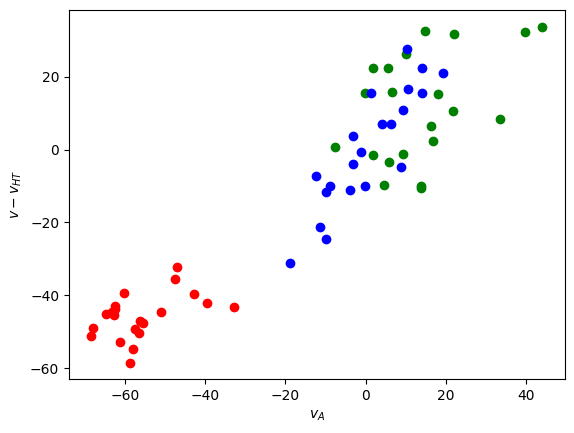

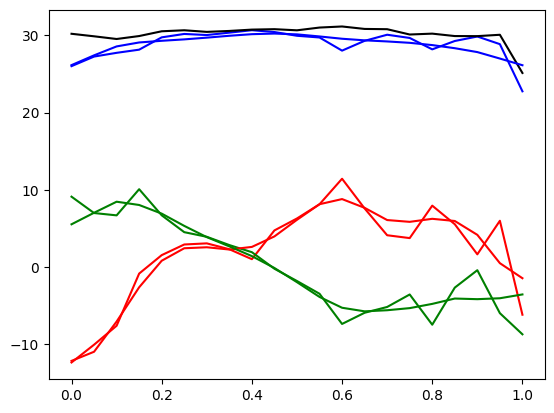

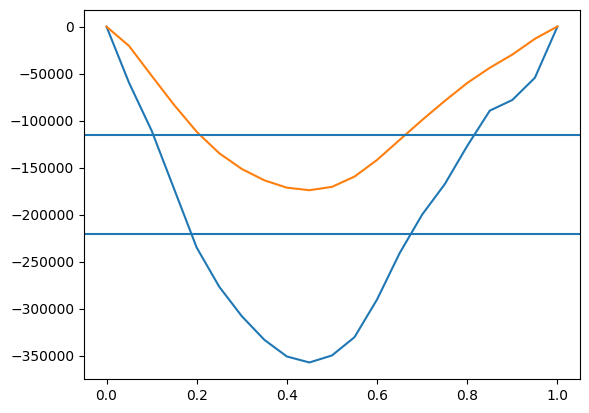

/tmp/ipykernel_293057/318852200.py:93: RuntimeWarning: divide by zero encountered in divide
  plt.scatter(A, (invariant - invariant.min()) / (invariant.max() - invariant.min()), color=color)
/tmp/ipykernel_293057/318852200.py:93: RuntimeWarning: invalid value encountered in divide
  plt.scatter(A, (invariant - invariant.min()) / (invariant.max() - invariant.min()), color=color)
/tmp/ipykernel_293057/318852200.py:94: RuntimeWarning: divide by zero encountered in divide
  plt.plot(A, (invariant - invariant.min()) / (invariant.max() - invariant.min()), color=color)
/tmp/ipykernel_293057/318852200.py:94: RuntimeWarning: invalid value encountered in divide
  plt.plot(A, (invariant - invariant.min()) / (invariant.max() - invariant.min()), color=color)


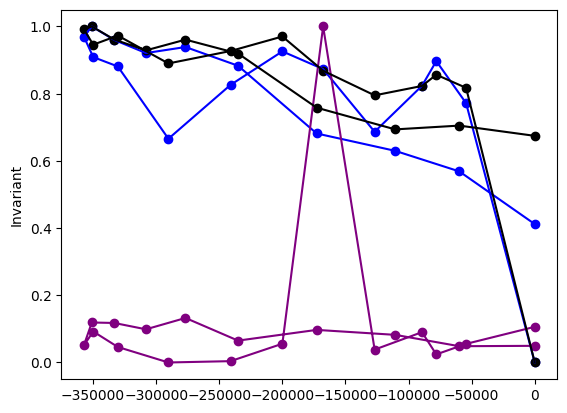

closed % 18
width 0.6666666666666666
height 0.8
poloidal flux per au 15669.067968750001
axial flux 132.37264384
twist per au 118.37089230981398
field line length 0.008448022824586676
<xarray.DataArray 'spatial_scale' ()>
array(0.00051954)
scale in au 0.00044255879637472605


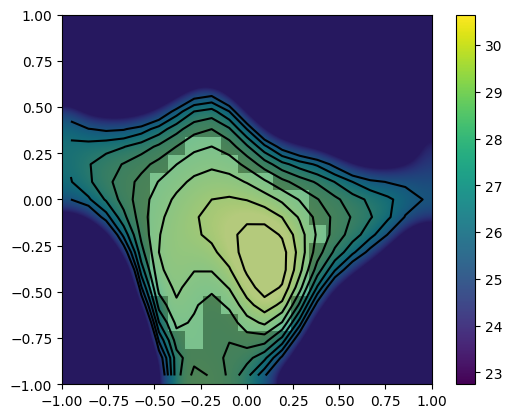

2018-11-13T02:15:15.000000000  to  2018-11-13T02:23:45.000000000
window length: 17
duration: 8.5
error: 0.141 0.088
walen slope: 0.619
alfvenicity: 0.639
<B>: 30.61
Altitude/azimuth: 99 / 156
Frame quality: 0.9987030029296875
Field alignment 0.9178676605224609


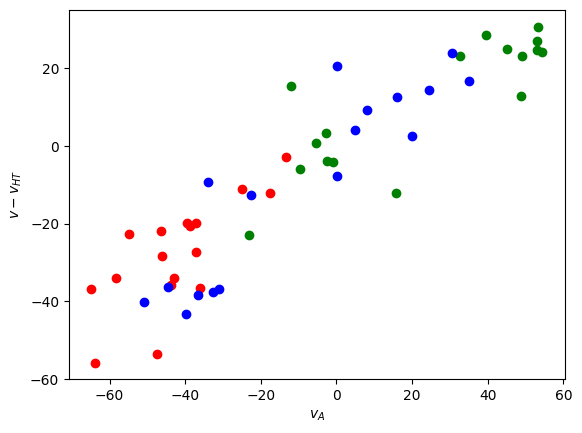

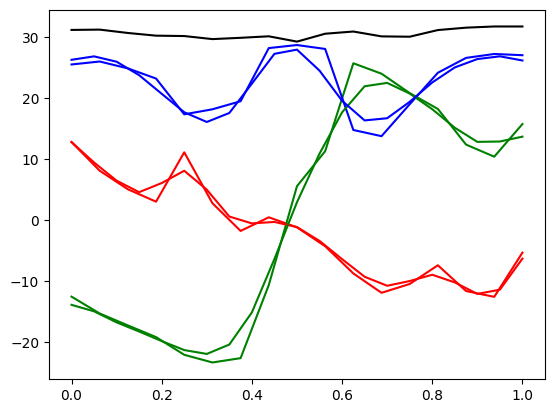

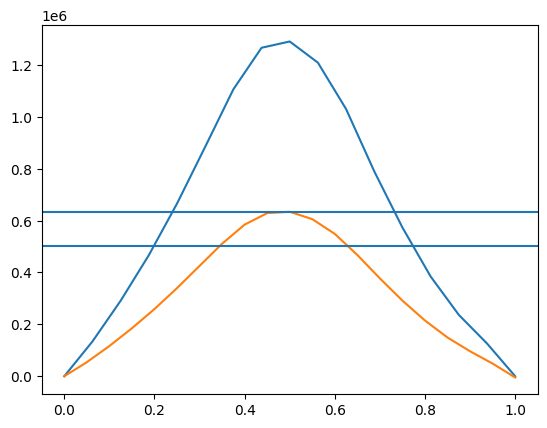

/tmp/ipykernel_293057/318852200.py:93: RuntimeWarning: divide by zero encountered in divide
  plt.scatter(A, (invariant - invariant.min()) / (invariant.max() - invariant.min()), color=color)
/tmp/ipykernel_293057/318852200.py:93: RuntimeWarning: invalid value encountered in divide
  plt.scatter(A, (invariant - invariant.min()) / (invariant.max() - invariant.min()), color=color)
/tmp/ipykernel_293057/318852200.py:94: RuntimeWarning: divide by zero encountered in divide
  plt.plot(A, (invariant - invariant.min()) / (invariant.max() - invariant.min()), color=color)
/tmp/ipykernel_293057/318852200.py:94: RuntimeWarning: invalid value encountered in divide
  plt.plot(A, (invariant - invariant.min()) / (invariant.max() - invariant.min()), color=color)


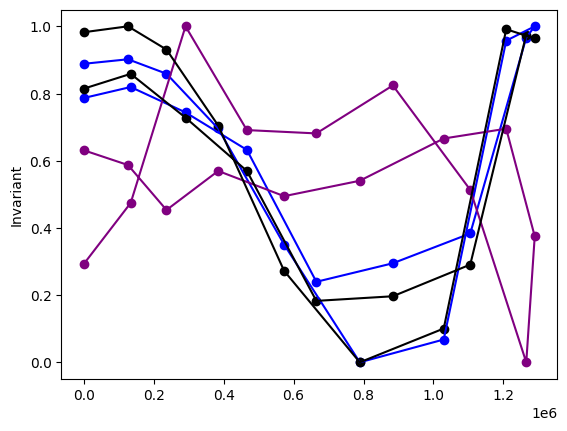

closed % 16
width 0.5333333333333333
height 1.0
poloidal flux per au 19804.396875000002
axial flux 140.54134579200002
twist per au 140.91509344382072
field line length 0.007096471893542579
<xarray.DataArray 'spatial_scale' ()>
array(0.00054706)
scale in au 0.0005498899742508378


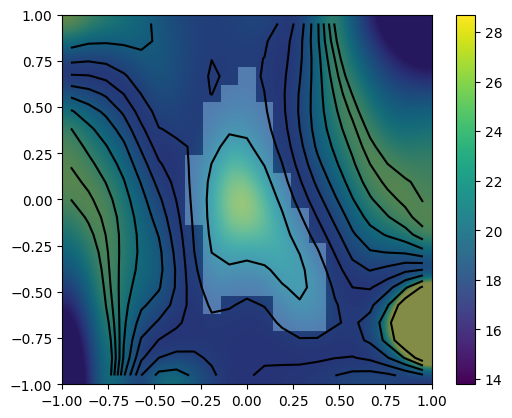

2018-11-13T03:12:45.000000000  to  2018-11-13T03:24:15.000000000
window length: 23
duration: 11.5
error: 0.151 0.106
walen slope: 0.48
alfvenicity: 0.479
<B>: 32.22
Altitude/azimuth: 46 / 158
Frame quality: 0.998753011226654
Field alignment 0.9154574871063232


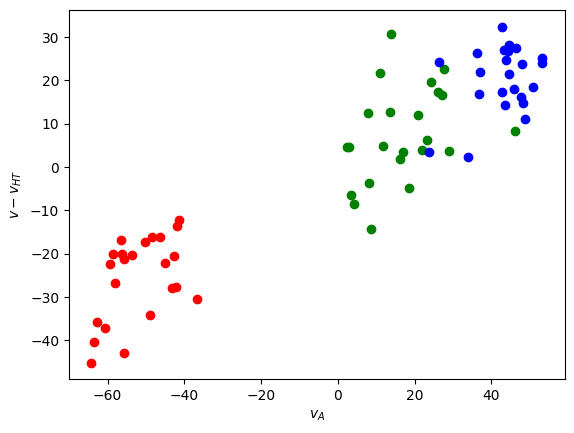

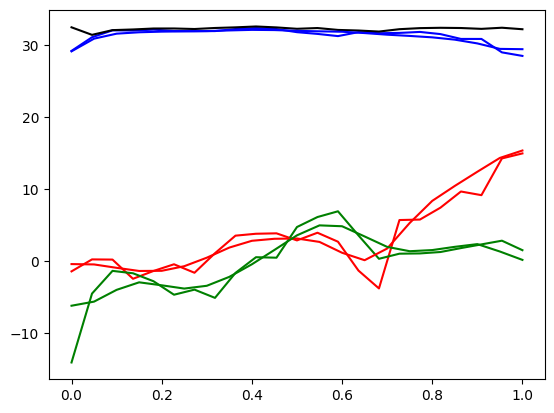

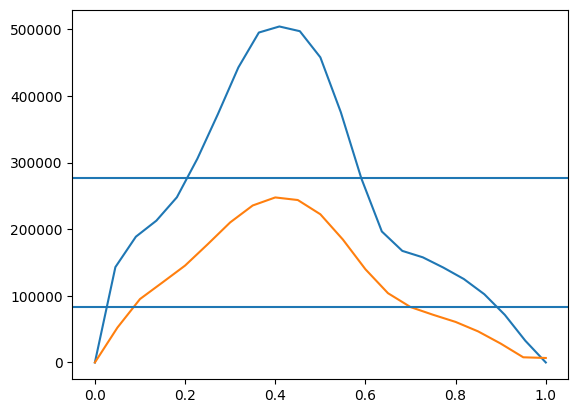

/tmp/ipykernel_293057/318852200.py:93: RuntimeWarning: divide by zero encountered in divide
  plt.scatter(A, (invariant - invariant.min()) / (invariant.max() - invariant.min()), color=color)
/tmp/ipykernel_293057/318852200.py:93: RuntimeWarning: invalid value encountered in divide
  plt.scatter(A, (invariant - invariant.min()) / (invariant.max() - invariant.min()), color=color)
/tmp/ipykernel_293057/318852200.py:94: RuntimeWarning: divide by zero encountered in divide
  plt.plot(A, (invariant - invariant.min()) / (invariant.max() - invariant.min()), color=color)
/tmp/ipykernel_293057/318852200.py:94: RuntimeWarning: invalid value encountered in divide
  plt.plot(A, (invariant - invariant.min()) / (invariant.max() - invariant.min()), color=color)


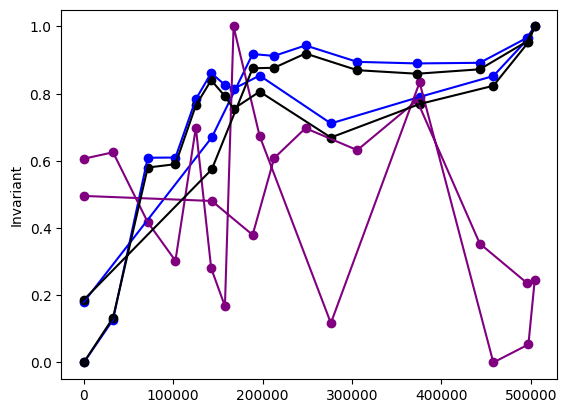

closed % 24
width 0.8
height 1.0666666666666667
poloidal flux per au 29126.165625
axial flux 822.6231418880001
twist per au 35.40645058702411
field line length 0.02824344105157165
<xarray.DataArray 'spatial_scale' ()>
array(0.00117445)
scale in au 0.001071108134879821


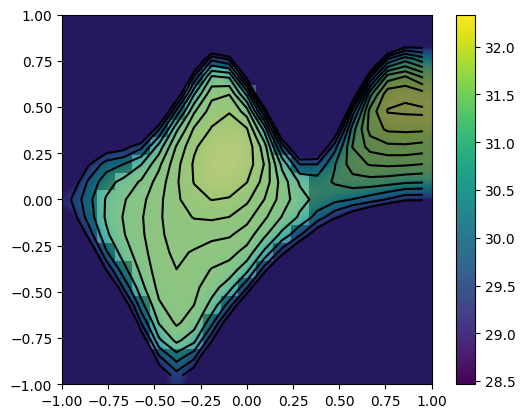

2018-11-13T03:52:45.000000000  to  2018-11-13T04:00:15.000000000
window length: 15
duration: 7.5
error: 0.203 0.112
walen slope: 0.542
alfvenicity: 0.542
<B>: 32.81
Altitude/azimuth: 66 / 173
Frame quality: 0.9950498938560486
Field alignment 0.9050013422966003


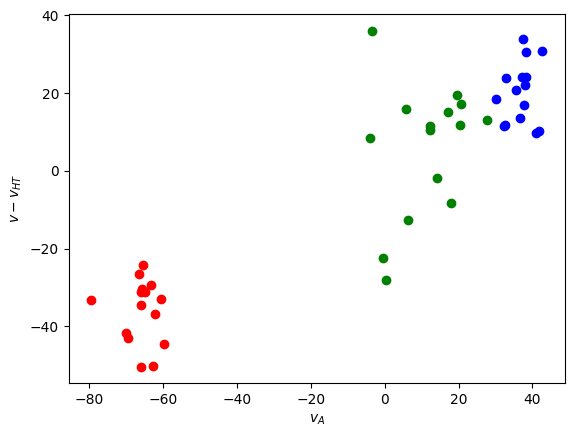

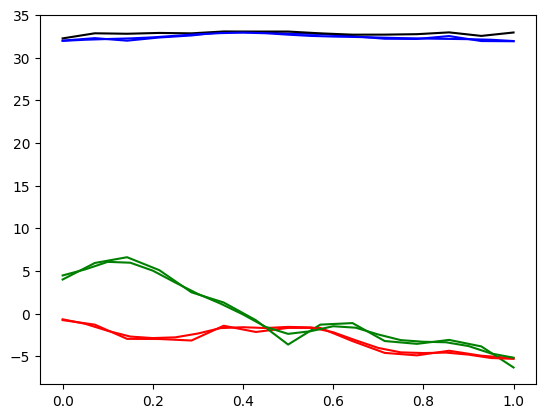

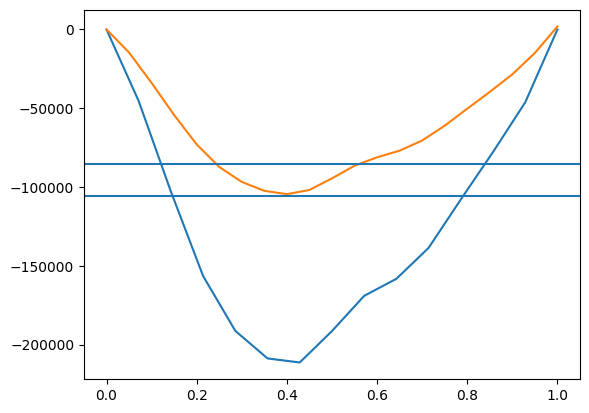

/tmp/ipykernel_293057/318852200.py:93: RuntimeWarning: invalid value encountered in divide
  plt.scatter(A, (invariant - invariant.min()) / (invariant.max() - invariant.min()), color=color)
/tmp/ipykernel_293057/318852200.py:94: RuntimeWarning: invalid value encountered in divide
  plt.plot(A, (invariant - invariant.min()) / (invariant.max() - invariant.min()), color=color)


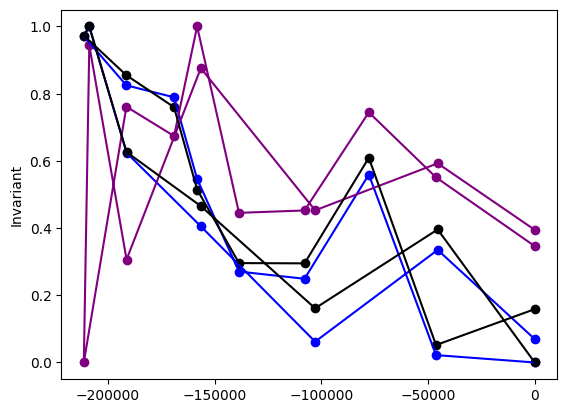

closed % 7
width 0.5333333333333333
height 0.5333333333333333
poloidal flux per au 3067.9828125000004
axial flux 95.592914944
twist per au 32.09424897543169
field line length 0.03115823027251721
<xarray.DataArray 'spatial_scale' ()>
array(0.00045694)
scale in au 0.00036044261322703874


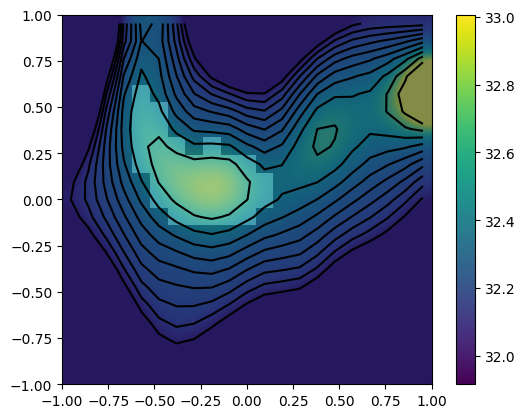

2018-11-13T09:25:45.000000000  to  2018-11-13T09:50:15.000000000
window length: 49
duration: 24.5
error: 0.21 0.108
walen slope: 0.086
alfvenicity: 0.083
<B>: 33.18
Altitude/azimuth: 122 / 125
Frame quality: 0.9997695088386536
Field alignment 0.4195193946361542


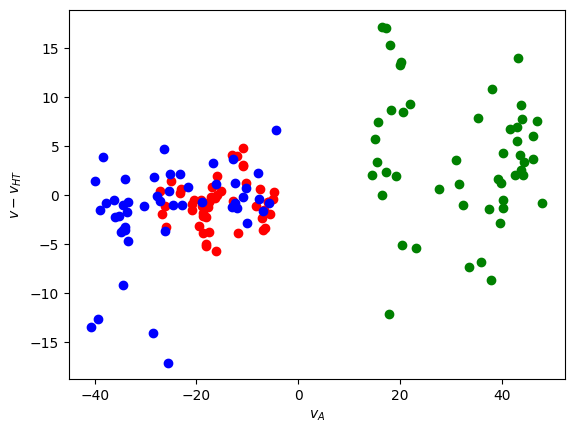

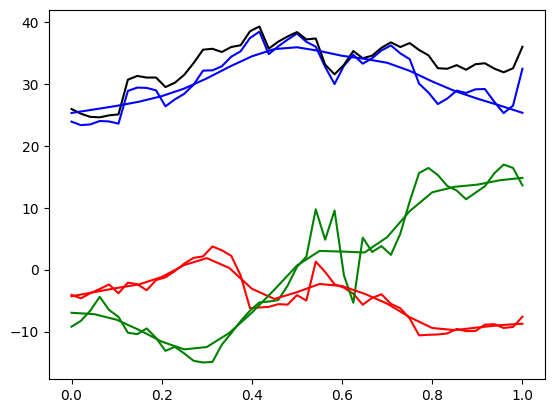

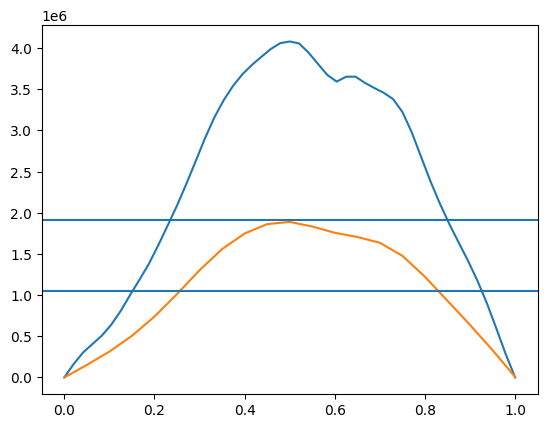

/tmp/ipykernel_293057/318852200.py:93: RuntimeWarning: divide by zero encountered in divide
  plt.scatter(A, (invariant - invariant.min()) / (invariant.max() - invariant.min()), color=color)
/tmp/ipykernel_293057/318852200.py:93: RuntimeWarning: invalid value encountered in divide
  plt.scatter(A, (invariant - invariant.min()) / (invariant.max() - invariant.min()), color=color)
/tmp/ipykernel_293057/318852200.py:94: RuntimeWarning: divide by zero encountered in divide
  plt.plot(A, (invariant - invariant.min()) / (invariant.max() - invariant.min()), color=color)
/tmp/ipykernel_293057/318852200.py:94: RuntimeWarning: invalid value encountered in divide
  plt.plot(A, (invariant - invariant.min()) / (invariant.max() - invariant.min()), color=color)


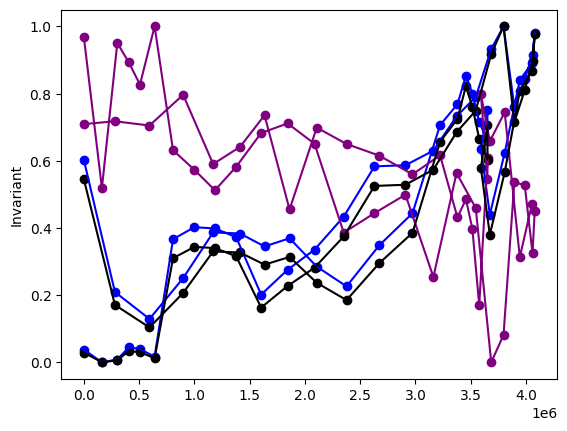

closed % 21
width 0.8666666666666667
height 0.8
poloidal flux per au 129169.6125
axial flux 1056.12443648
twist per au 122.30529664715897
field line length 0.008176260778671918
<xarray.DataArray 'spatial_scale' ()>
array(0.00305591)
scale in au 0.0012093103124777144


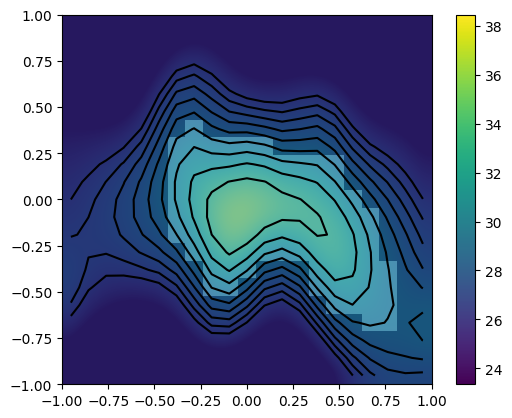

2018-11-13T11:10:15.000000000  to  2018-11-13T11:29:45.000000000
window length: 39
duration: 19.5
error: 0.225 0.159
walen slope: 0.252
alfvenicity: 0.253
<B>: 21.91
Altitude/azimuth: 28 / 162
Frame quality: 0.9999240636825562
Field alignment 0.8215215802192688


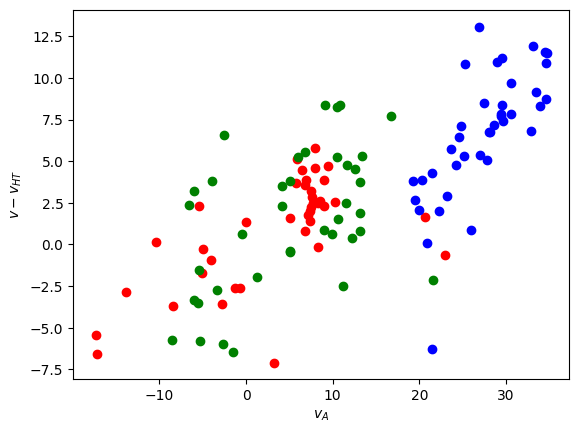

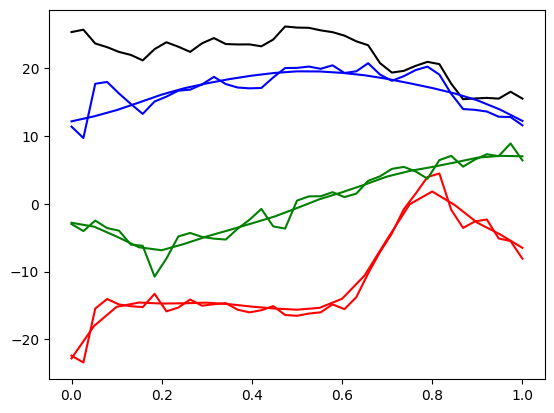

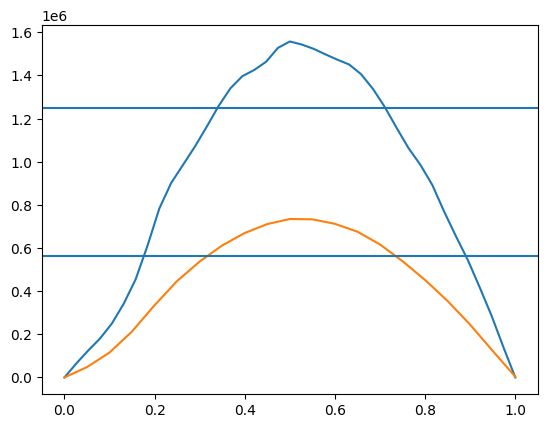

/tmp/ipykernel_293057/318852200.py:93: RuntimeWarning: divide by zero encountered in divide
  plt.scatter(A, (invariant - invariant.min()) / (invariant.max() - invariant.min()), color=color)
/tmp/ipykernel_293057/318852200.py:93: RuntimeWarning: invalid value encountered in divide
  plt.scatter(A, (invariant - invariant.min()) / (invariant.max() - invariant.min()), color=color)
/tmp/ipykernel_293057/318852200.py:94: RuntimeWarning: divide by zero encountered in divide
  plt.plot(A, (invariant - invariant.min()) / (invariant.max() - invariant.min()), color=color)
/tmp/ipykernel_293057/318852200.py:94: RuntimeWarning: invalid value encountered in divide
  plt.plot(A, (invariant - invariant.min()) / (invariant.max() - invariant.min()), color=color)


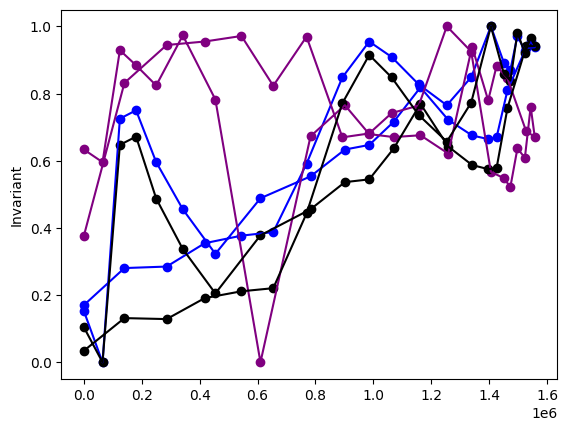

closed % 18
width 0.8
height 0.6
poloidal flux per au 103009.55625
axial flux 605.486972928
twist per au 170.1267919140667
field line length 0.00587796894744899
<xarray.DataArray 'spatial_scale' ()>
array(0.00239061)
scale in au 0.0011033581420898436


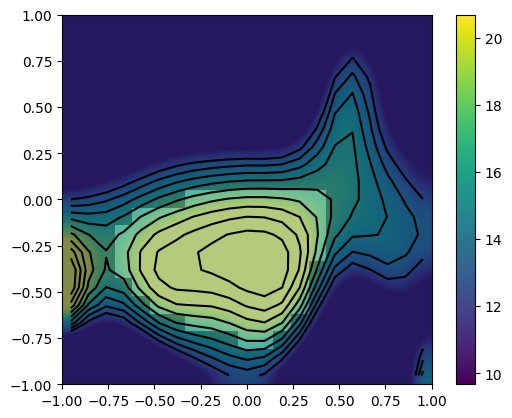

2018-11-13T12:33:15.000000000  to  2018-11-13T12:54:45.000000000
window length: 43
duration: 21.5
error: 0.23 0.158
walen slope: 0.448
alfvenicity: 0.448
<B>: 15.02
Altitude/azimuth: 70 / 139
Frame quality: 0.9997307062149048
Field alignment 0.8369210362434387


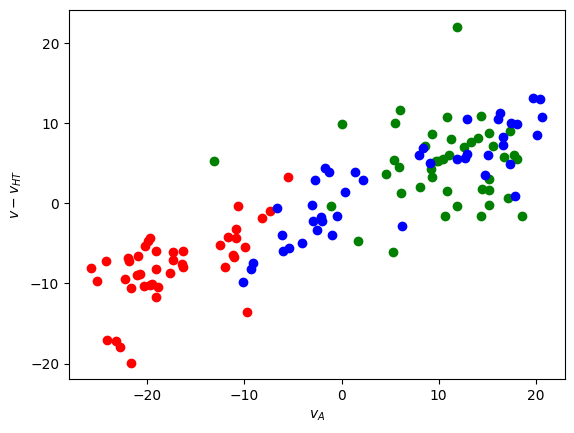

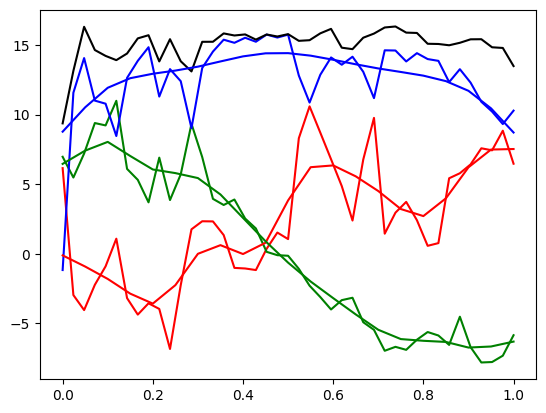

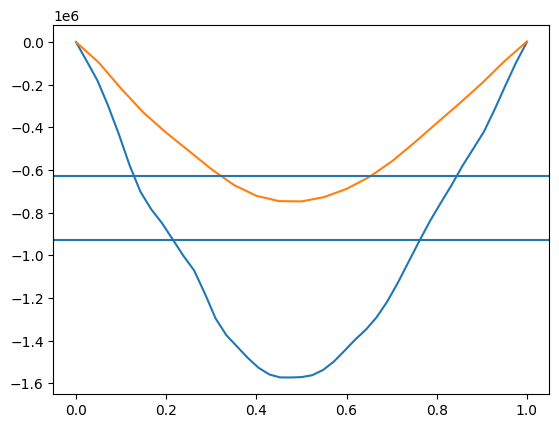

/tmp/ipykernel_293057/318852200.py:93: RuntimeWarning: divide by zero encountered in divide
  plt.scatter(A, (invariant - invariant.min()) / (invariant.max() - invariant.min()), color=color)
/tmp/ipykernel_293057/318852200.py:93: RuntimeWarning: invalid value encountered in divide
  plt.scatter(A, (invariant - invariant.min()) / (invariant.max() - invariant.min()), color=color)
/tmp/ipykernel_293057/318852200.py:94: RuntimeWarning: divide by zero encountered in divide
  plt.plot(A, (invariant - invariant.min()) / (invariant.max() - invariant.min()), color=color)
/tmp/ipykernel_293057/318852200.py:94: RuntimeWarning: invalid value encountered in divide
  plt.plot(A, (invariant - invariant.min()) / (invariant.max() - invariant.min()), color=color)


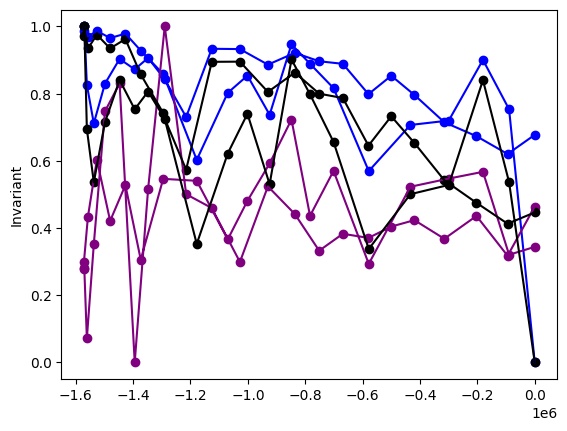

closed % 16
width 0.5333333333333333
height 1.0
poloidal flux per au 44814.3
axial flux 213.05912524800002
twist per au 210.33738849643885
field line length 0.004754266500826745
<xarray.DataArray 'spatial_scale' ()>
array(0.00205893)
scale in au 0.0008069223335128216


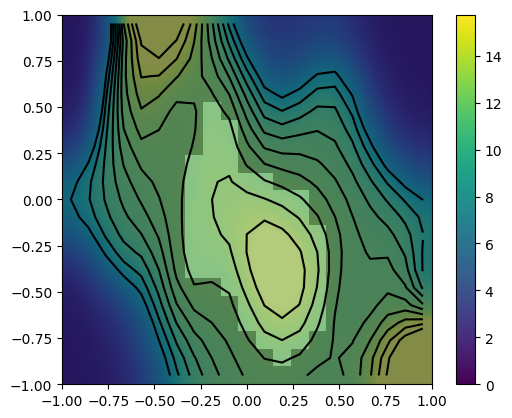

2018-11-13T19:53:45.000000000  to  2018-11-13T20:00:45.000000000
window length: 14
duration: 7.0
error: 0.157 0.099
walen slope: 0.756
alfvenicity: 0.751
<B>: 23.09
Altitude/azimuth: 92 / 359
Frame quality: 0.9997420310974121
Field alignment 0.9896195530891418


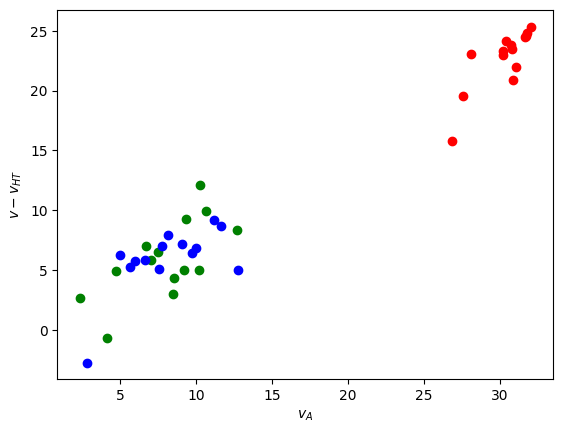

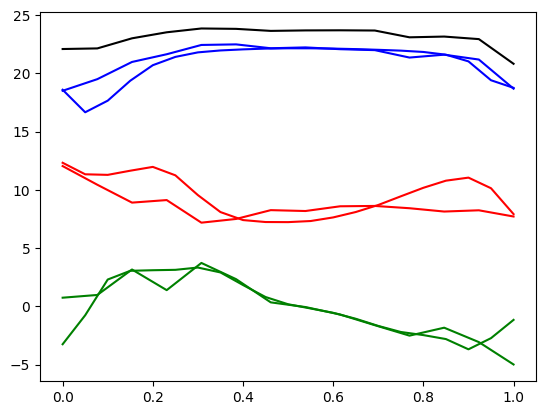

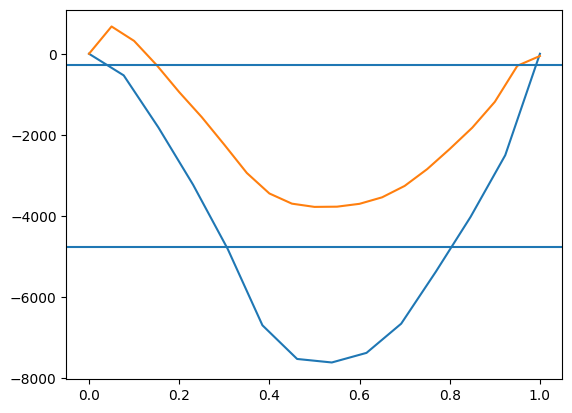

/tmp/ipykernel_293057/318852200.py:93: RuntimeWarning: invalid value encountered in divide
  plt.scatter(A, (invariant - invariant.min()) / (invariant.max() - invariant.min()), color=color)
/tmp/ipykernel_293057/318852200.py:94: RuntimeWarning: invalid value encountered in divide
  plt.plot(A, (invariant - invariant.min()) / (invariant.max() - invariant.min()), color=color)


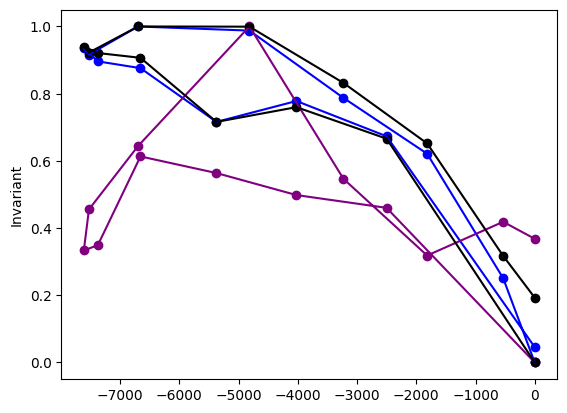

closed % 21
width 1.2
height 0.5333333333333333
poloidal flux per au 675.2081542968751
axial flux 0.788277568
twist per au 856.5614216449137
field line length 0.0011674586021859722
<xarray.DataArray 'spatial_scale' ()>
array(2.89626042e-05)
scale in au 4.010934335152329e-05


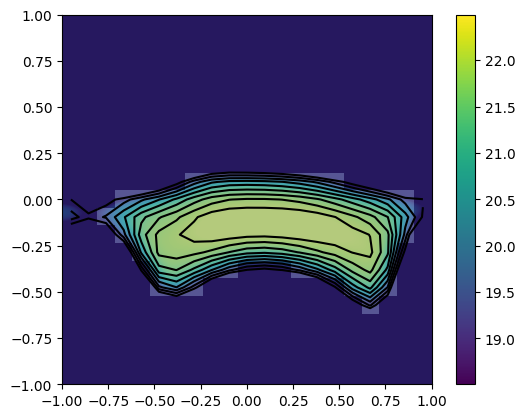

2018-11-13T21:45:15.000000000  to  2018-11-13T22:09:15.000000000
window length: 48
duration: 24.0
error: 0.19 0.164
walen slope: 0.673
alfvenicity: 0.676
<B>: 21.74
Altitude/azimuth: 79 / 357
Frame quality: 0.9996492266654968
Field alignment 0.9672850370407104


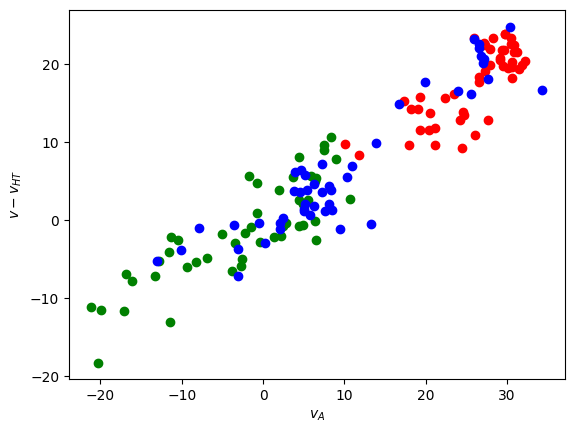

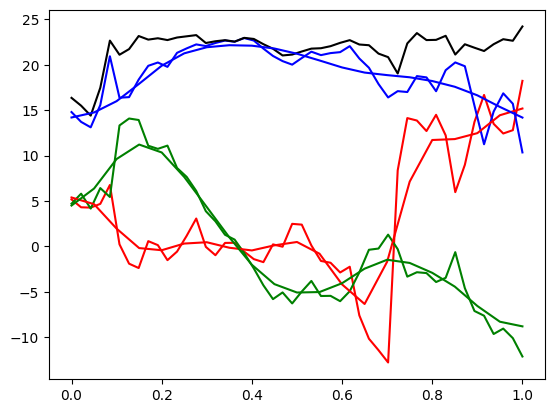

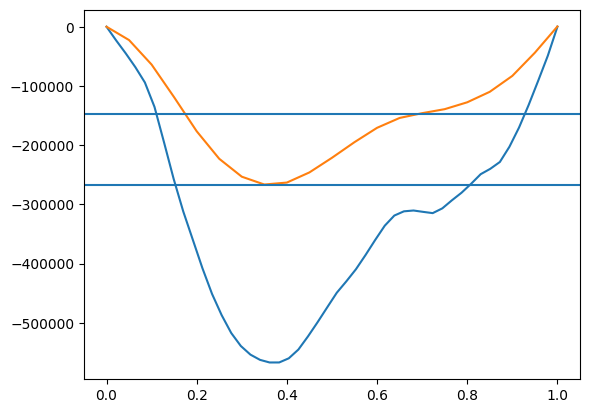

/tmp/ipykernel_293057/318852200.py:93: RuntimeWarning: invalid value encountered in divide
  plt.scatter(A, (invariant - invariant.min()) / (invariant.max() - invariant.min()), color=color)
/tmp/ipykernel_293057/318852200.py:94: RuntimeWarning: invalid value encountered in divide
  plt.plot(A, (invariant - invariant.min()) / (invariant.max() - invariant.min()), color=color)


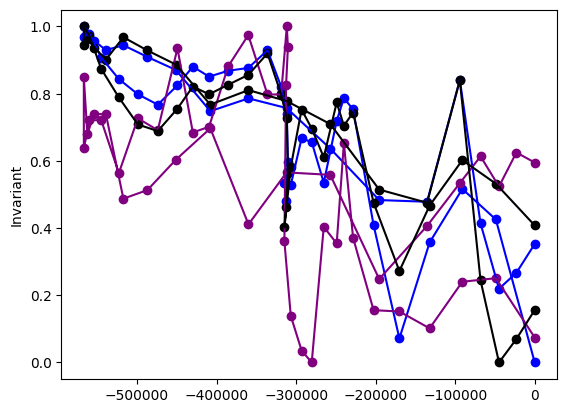

closed % 18
width 0.6666666666666666
height 1.0
poloidal flux per au 17978.91796875
axial flux 32.357732352
twist per au 555.6297262480676
field line length 0.001799759719035511
<xarray.DataArray 'spatial_scale' ()>
array(0.00070275)
scale in au 0.00026353245849609376


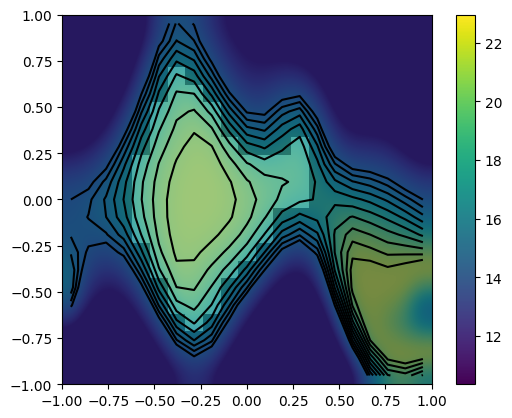

2018-11-13T23:20:15.000000000  to  2018-11-13T23:43:15.000000000
window length: 46
duration: 23.0
error: 0.182 0.145
walen slope: 0.273
alfvenicity: 0.288
<B>: 26.8
Altitude/azimuth: 45 / 335
Frame quality: 0.9999116063117981
Field alignment 0.9098281264305115


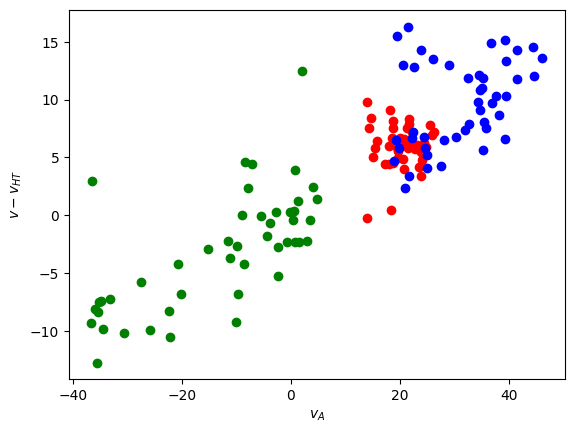

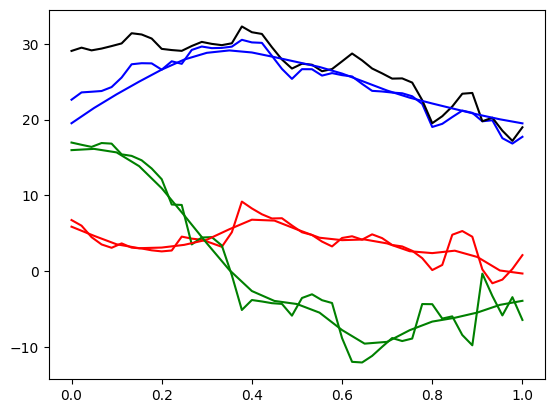

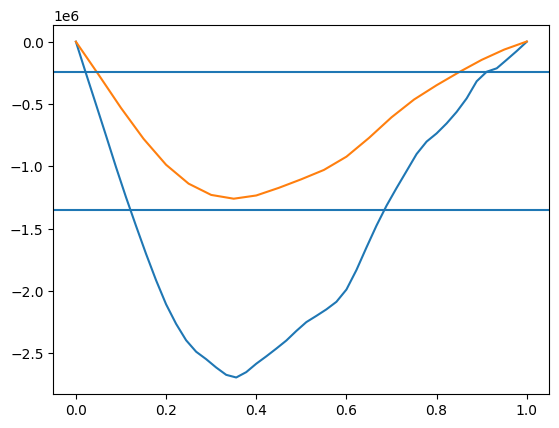

/tmp/ipykernel_293057/318852200.py:93: RuntimeWarning: divide by zero encountered in divide
  plt.scatter(A, (invariant - invariant.min()) / (invariant.max() - invariant.min()), color=color)
/tmp/ipykernel_293057/318852200.py:93: RuntimeWarning: invalid value encountered in divide
  plt.scatter(A, (invariant - invariant.min()) / (invariant.max() - invariant.min()), color=color)
/tmp/ipykernel_293057/318852200.py:94: RuntimeWarning: divide by zero encountered in divide
  plt.plot(A, (invariant - invariant.min()) / (invariant.max() - invariant.min()), color=color)
/tmp/ipykernel_293057/318852200.py:94: RuntimeWarning: invalid value encountered in divide
  plt.plot(A, (invariant - invariant.min()) / (invariant.max() - invariant.min()), color=color)


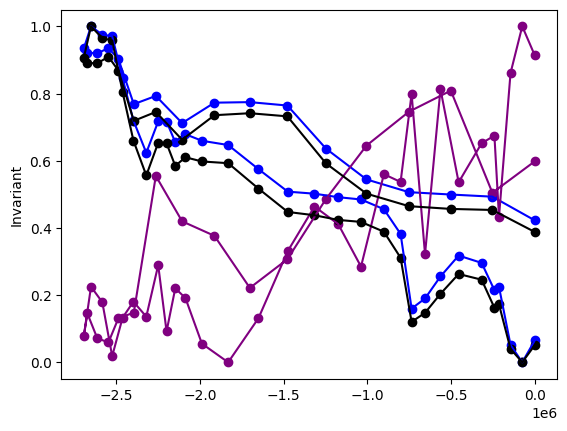

closed % 43
width 1.1333333333333333
height 1.2666666666666666
poloidal flux per au 166402.70625
axial flux 1070.0898304
twist per au 155.50349281218624
field line length 0.0064307237214779375
<xarray.DataArray 'spatial_scale' ()>
array(0.00230539)
scale in au 0.0013816344179302532


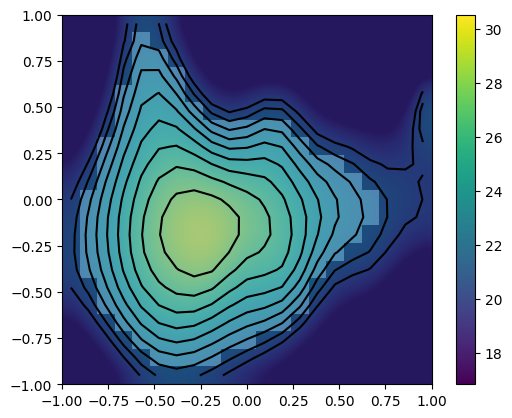

In [11]:
def spherical(x, y, z):
    altitude = np.rad2deg(np.arctan2(np.sqrt(x ** 2 + y ** 2), z))
    azimuth = np.rad2deg(np.arctan2(y, x))
    return altitude, azimuth


for i_event in list(sorted(results.event, reverse=False, key=lambda x: results.window_start.sel(event=x)))[:10]:
    event = results.sel(event=i_event)
    axis = event[["axis_x", "axis_y", "axis_z"]].to_array().values
    propagation_velocity = event[["velocity_x", "velocity_y", "velocity_z"]].to_array().values
    window_start = event.window_start.item()
    window_length = event.window_length.item()
    temporal_scale = event.temporal_scale.item()
    residue = event.residue_diff.item()
    error_fit = event.residue_fit.item()

    event_flow_velocity = velocity[window_start:window_start + window_length].cpu().numpy()
    event_magnetic_field = magnetic_field[window_start:window_start + window_length].cpu().numpy()
    event_density = density[window_start:window_start + window_length].cpu().numpy()
    Pgas = gas_pressure[window_start:window_start + window_length].cpu().numpy()

    x_unit = -(propagation_velocity - np.dot(propagation_velocity, axis) * axis)
    x_unit = x_unit / np.linalg.norm(x_unit)
    y_unit = np.cross(axis, x_unit)
    rotation_matrix = np.column_stack([x_unit, y_unit, axis])
    rotation_matrix = rotation_matrix.T  # transpose gives inverse of rotation matrix
    alfven_velocity = event_magnetic_field / np.sqrt(scipy.constants.mu_0
                                            * scipy.constants.m_p
                                            * np.expand_dims(event_density, axis=1)) * 1e-15
    remaining_flow = event_flow_velocity - propagation_velocity

    d_flow = remaining_flow - remaining_flow.mean()
    d_alfven = alfven_velocity - alfven_velocity.mean()
    walen_slope = (d_flow * d_alfven).sum() / (d_alfven ** 2).sum()

    # if walen_slope > 0.3:
    #     continue

    print(times[window_start], " to ", times[window_start + window_length])
    print("window length:", window_length)
    print("duration:", temporal_scale / 60)
    print("error:", round(residue, 3), round(error_fit, 3))
    print("walen slope:", round(walen_slope, 3))
    print("alfvenicity:", round(event.walen_slope.item(), 3))
    print("<B>:", round(np.linalg.norm(event_magnetic_field, axis=1).mean(), 2))
    altitude, azimuth = spherical(*axis)
    print("Altitude/azimuth:", round(altitude), "/", round(azimuth % 360))
    print("Frame quality:", event.frame_quality.item())
    print("Field alignment", event.flow_field_alignment.item())

    rotated = rotation_matrix @ event_magnetic_field.T

    dx = np.linalg.norm(np.dot(propagation_velocity, x_unit)) * 60
    A = scipy.integrate.cumulative_trapezoid(-rotated[1], initial=0, dx=dx)
    alpha = event.walen_slope.item() ** 2
    Pt = Pgas / (1 - alpha) + ((rotated[2] * 1e-9) ** 2 + (alpha / (1 - alpha)) * (np.linalg.norm(rotated, axis=0)* 1e-9) ** 2) / (2 * 1.25663706212e-6) * 1e9

    colors = ["red", "green", "blue"]

    A_peak = A[np.abs(A).argmax()]
    A_sign = np.sign(A_peak)

    map_core_mask = event.map_core_mask.values
    map_A = event.map_Az.values
    
    closed_min = (map_A[map_core_mask] * A_sign).min()
    closed_max = (map_A[map_core_mask] * A_sign).max()

    for i, color in enumerate(colors):
        plt.scatter(alfven_velocity[:, i], remaining_flow[:, i], color=color)
        plt.xlabel(r"$v_A$")
        plt.ylabel(r"$v - v_{HT}$")
    plt.show()

    for i_color, color in enumerate(colors):
        plt.plot(np.linspace(0, 1, len(rotated[i_color])), rotated[i_color], color=color)
    plt.plot(np.linspace(0, 1, len(rotated[0])), np.linalg.norm(rotated, axis=0), color="black")

    resolution = 21

    plt.plot(np.linspace(0, 1, resolution), event.map_Bx[event.map_Bx.shape[0] // 2, :], color="red")
    plt.plot(np.linspace(0, 1, resolution), event.map_By[event.map_By.shape[0] // 2, :], color="green")
    plt.plot(np.linspace(0, 1, resolution), event.map_Bz[event.map_Bz.shape[0] // 2, :], color="blue")
    
    plt.show()
    plt.plot(np.linspace(0, 1, len(A)), A)
    plt.plot(np.linspace(0, 1, resolution), map_A[map_A.shape[0] // 2, :])
    plt.axhline(closed_min * A_sign)
    plt.axhline(closed_max * A_sign)
    plt.show()

    def plot_invariant(invariant, color):
        plt.scatter(A, (invariant - invariant.min()) / (invariant.max() - invariant.min()), color=color)
        plt.plot(A, (invariant - invariant.min()) / (invariant.max() - invariant.min()), color=color)
    plot_invariant(rotated[2], "blue")
    plot_invariant(event_density, "purple")
    plot_invariant(Pgas, "red")
    plot_invariant(Pt, color="black")
    plt.ylabel("Invariant")
    plt.show()

    extent = (-1, 1, -1, 1)

    plt.imshow(event.map_Bz, vmin=max(0, rotated[2].min()), vmax=rotated[2].max(), interpolation="bicubic", extent=extent, origin="lower")
    # plt.imshow(map_A / A_peak, vmin=0, cmap="gist_heat", extent=extent, origin="lower")
    plt.colorbar()
    enclosed_levels = (map_A[map_core_mask] * A_sign)
    levels = np.linspace(0, enclosed_levels.max(), 10)
    plt.contour(map_A * A_sign, origin="lower", extent=extent, levels=levels, colors="black", algorithm="serial", antialiased=True)
   
    plt.xlim(extent[0], extent[1])
    plt.ylim(extent[2], extent[3])
    

    print("closed %", int(100 * map_core_mask.mean()))
    print("width", np.any(map_core_mask, axis=-2).sum() / 15)
    print("height", np.any(map_core_mask, axis=-1).sum() / 15)

    poloidal_flux = (closed_max - closed_min) * 1e-9 * 1.5e8
    axial_flux = (event.map_Bz.values[map_core_mask] * dx ** 2).sum().item() * 1e-9

    print("poloidal flux per au", poloidal_flux)
    print("axial flux", axial_flux)
    print("twist per au", poloidal_flux / axial_flux)
    print("field line length", axial_flux / poloidal_flux)
    print(event.spatial_scale / 1.5e8)
    print("scale in au", np.sqrt(np.count_nonzero(map_core_mask) * (dx / 1.5e8) ** 2))

    plt.imshow(map_core_mask, vmin=0, vmax=2, origin="lower", extent=extent, cmap="Blues_r", alpha=0.5)


    plt.show()

